In [5]:
import yfinance as yf
import finnhub
import GetOldTweets3 as got
import requests
import pytrends
from pytrends.request import TrendReq
from ta import add_all_ta_features
import praw
import pandas as pd
import os
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import keras
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import numpy as np
import plotly.express as px
import alpha_vantage

In [62]:
from pytrends import dailydata
res = dailydata.get_daily_data("NVDA", start_year=2024, start_mon=1, stop_year=2024, stop_mon=3, geo = '')
display(res)


NVDA:2024-01-01 2024-01-31
NVDA:2024-02-01 2024-02-29
NVDA:2024-03-01 2024-03-31


,NVDA_unscaled,NVDA_monthly,isPartial,scale,NVDA
date,,,,,
2024-01-01,11,2,False,0.02,0.22
2024-01-02,53,11,False,0.11,5.83
2024-01-03,51,10,False,0.10,5.10
2024-01-04,46,9,False,0.09,4.14
2024-01-05,49,10,False,0.10,4.90
...,...,...,...,...,...
2024-03-27,49,26,False,0.26,12.74
2024-03-28,51,27,False,0.27,13.77
2024-03-29,19,10,False,0.10,1.90


In [65]:
res = res[['NVDA_unscaled']]
res.to_csv('nvda_daily.csv',header=True)

In [66]:
nvda_daily = res
fig = px.line(nvda_daily, y=['NVDA_unscaled'], title='Keyword Web Search Interest Over Time')
fig.show()

In [70]:
finnhub_client = finnhub.Client(api_key="cp498o1r01qs3666htc0cp498o1r01qs3666htcg")
news = finnhub_client.company_news('NVDA', _from="2024-01-01", to="2024-03-31")
df = pd.DataFrame(news)
display(df)

,category,datetime,headline,id,image,related,source,summary,url
0,company,1711929540,Spear Advisors Q4 2023 Fund Letter,126771744,https://media.gettyimages.com/id/1569391851/ph...,NVDA,SeekingAlpha,Spear Alpha ETF was up 88.02% in 2023 vs. S&P ...,https://finnhub.io/api/news?id=57a63a9c0efd597...
1,company,1711927509,China criticises US tightening of chip export ...,126771584,,NVDA,Finnhub,China has criticised thetightening of U.S. rul...,https://finnhub.io/api/news?id=ce2a74e9ecdec34...
2,company,1711900395,12 Best S&P 500 Stocks To Buy According to Ana...,126767975,https://s.yimg.com/ny/api/res/1.2/RDyivIe93nno...,NVDA,Yahoo,"In this piece, we will take a look at the 12 b...",https://finnhub.io/api/news?id=0b79d8eff60a4d8...
3,company,1711899660,"Nvidia Invested in SoundHound AI Stock, But Sh...",126769488,https://g.foolcdn.com/editorial/images/771102/...,NVDA,Yahoo,SoundHound AI's stock has soared since it was ...,https://finnhub.io/api/news?id=b18e1e51c352edf...
4,company,1711897860,4 Things I Look For in an Artificial Intellige...,126769489,https://g.foolcdn.com/editorial/images/771075/...,NVDA,Yahoo,Don't get too caught up in the AI hype. Learn ...,https://finnhub.io/api/news?id=fbd9d07db906473...
...,...,...,...,...,...,...,...,...,...
220,company,1711518271,The Peak Fed Dovishness - That's Negative For ...,126704773,https://static.seekingalpha.com/cdn/s3/uploads...,NVDA,SeekingAlpha,The Fed will be forced to delay interest rate ...,https://finnhub.io/api/news?id=d40b57965e30f23...
221,company,1711517940,From $170 to $375: 3 Factors That Could Drive ...,126710872,,NVDA,InvestorPlace,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=9d671097cf910ad...
222,company,1711517580,NVDA Stock’s Race to $1K: 3 Reasons It Will Ge...,126708812,,NVDA,InvestorPlace,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=e44616f5c38c94e...
223,company,1711516980,Nvidia’s Stock Reaches Crossroads At Key Fibon...,126712285,,NVDA,TalkMarkets,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=b3f2fe0865d9114...


In [71]:
vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df.iloc[:,2].apply(f)

df['date'] = pd.to_datetime(df['datetime'], unit='s').dt.strftime('%Y-%m-%d')

In [72]:
# Drop the old 'datetime' column
df = df.drop(columns=['datetime'])
display(df)
#display(df.iloc[:,2])

df_filtered = df[['related', 'date', 'compound']]

# Group by 'date' and calculate the average of 'compound'
df_grouped = df_filtered.groupby('date', as_index=False).agg({'related': 'first', 'compound': 'mean'})

# Display the resulting DataFrame
print(df_grouped)

,category,headline,id,image,related,source,summary,url,compound,date
0,company,Spear Advisors Q4 2023 Fund Letter,126771744,https://media.gettyimages.com/id/1569391851/ph...,NVDA,SeekingAlpha,Spear Alpha ETF was up 88.02% in 2023 vs. S&P ...,https://finnhub.io/api/news?id=57a63a9c0efd597...,0.0000,2024-03-31
1,company,China criticises US tightening of chip export ...,126771584,,NVDA,Finnhub,China has criticised thetightening of U.S. rul...,https://finnhub.io/api/news?id=ce2a74e9ecdec34...,-0.3182,2024-03-31
2,company,12 Best S&P 500 Stocks To Buy According to Ana...,126767975,https://s.yimg.com/ny/api/res/1.2/RDyivIe93nno...,NVDA,Yahoo,"In this piece, we will take a look at the 12 b...",https://finnhub.io/api/news?id=0b79d8eff60a4d8...,0.6369,2024-03-31
3,company,"Nvidia Invested in SoundHound AI Stock, But Sh...",126769488,https://g.foolcdn.com/editorial/images/771102/...,NVDA,Yahoo,SoundHound AI's stock has soared since it was ...,https://finnhub.io/api/news?id=b18e1e51c352edf...,0.0000,2024-03-31
4,company,4 Things I Look For in an Artificial Intellige...,126769489,https://g.foolcdn.com/editorial/images/771075/...,NVDA,Yahoo,Don't get too caught up in the AI hype. Learn ...,https://finnhub.io/api/news?id=fbd9d07db906473...,0.4767,2024-03-31
...,...,...,...,...,...,...,...,...,...,...
220,company,The Peak Fed Dovishness - That's Negative For ...,126704773,https://static.seekingalpha.com/cdn/s3/uploads...,NVDA,SeekingAlpha,The Fed will be forced to delay interest rate ...,https://finnhub.io/api/news?id=d40b57965e30f23...,-0.5719,2024-03-27
221,company,From $170 to $375: 3 Factors That Could Drive ...,126710872,,NVDA,InvestorPlace,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=9d671097cf910ad...,0.3818,2024-03-27
222,company,NVDA Stock’s Race to $1K: 3 Reasons It Will Ge...,126708812,,NVDA,InvestorPlace,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=e44616f5c38c94e...,0.0000,2024-03-27
223,company,Nvidia’s Stock Reaches Crossroads At Key Fibon...,126712285,,NVDA,TalkMarkets,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=b3f2fe0865d9114...,0.0516,2024-03-27


         date related  compound
0  2024-03-27    NVDA  0.074990
1  2024-03-28    NVDA  0.206570
2  2024-03-29    NVDA  0.258973
3  2024-03-30    NVDA  0.141742
4  2024-03-31    NVDA  0.322500


<Figure size 1000x800 with 0 Axes>

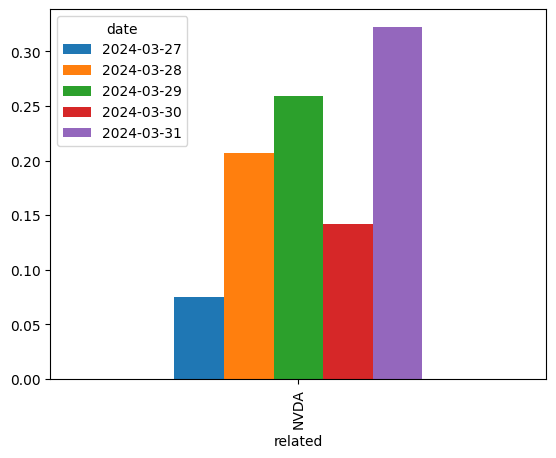

In [73]:
plt.figure(figsize=(10,8))
mean_df = df.groupby(['related', 'date']).mean(numeric_only=True).unstack()
mean_df = mean_df.xs('compound', axis="columns")
mean_df.plot(kind='bar')
plt.show()

In [ ]:
# Get stock financial data
NVDA = yf.Ticker("NVDA")
NVDA = NVDA.history(start='2024-01-01',end='2024-03-31')
nvda = NVDA[['Close', 'Volume']]
nvda.index = nvda.index.tz_localize(None)
sentiment_transposed = mean_df.T
sentiment_transposed.index = pd.to_datetime(sentiment_transposed.index)

In [75]:
# Merge DataFrames
merged_df = pd.merge(nvda, sentiment_transposed[['NVDA']], left_index=True, right_index=True, how='left')
merged_df = pd.merge(merged_df, nvda_daily[['NVDA_unscaled']], left_index=True, right_index=True, how='left')
merged_df = merged_df.rename(columns={'NVDA': 'Sentiment'})
merged_df = merged_df.rename(columns={'NVDA_unscaled': 'Trend'})
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(0)
merged_df['Trend'] = merged_df['Trend'].fillna(0)
merged_df=merged_df[['Close','Sentiment','Trend']]
display(merged_df)

,Close,Sentiment,Trend
Date,,,
2024-01-02,481.657410,0.00000,53
2024-01-03,475.667694,0.00000,51
2024-01-04,479.957489,0.00000,46
2024-01-05,490.946960,0.00000,49
2024-01-08,522.505493,0.00000,76
...,...,...,...
2024-03-22,942.890015,0.00000,48
2024-03-25,950.020020,0.00000,53
2024-03-26,925.609985,0.00000,48


In [78]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_df)

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
seq_length = 10  # You can adjust this as needed
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


In [79]:
# Define the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\razva\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [88]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0246 
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0164 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0102
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0127
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0088
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0103
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0076
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0084
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0121
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0113


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Day 1: Predicted Close = 915.52, Trend = Bullish
Day 2: Predicted Close = 913.24, Trend = Bullish
Day 3: Predicted Close = 914.09, Trend = Bullish


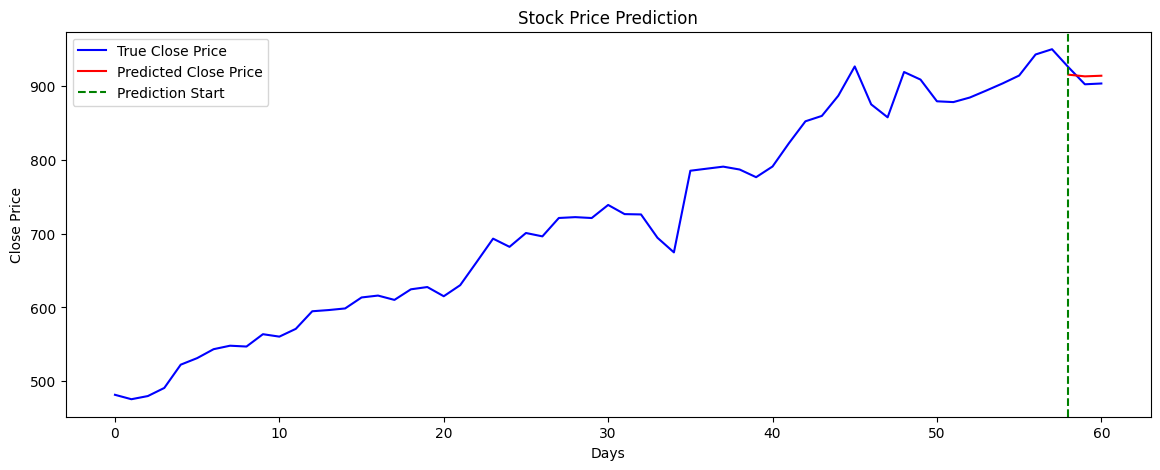

In [89]:
# Make predictions
predictions = model.predict(X_test)

# Create a placeholder array for the full feature set
# We need to have the same number of columns as the original data
full_scaler_predictions = np.zeros((predictions.shape[0], scaled_data.shape[1]))

# Place the predicted 'Close' values into the placeholder array
full_scaler_predictions[:, 0] = predictions[:, 0]

# Apply inverse transformation to the full array
inverse_predictions = scaler.inverse_transform(full_scaler_predictions)

# Extract only the 'Close' values from the inverse transformed data
final_predictions = inverse_predictions[:, 0]

# Extract true 'Close' values from test data
true_close = scaler.inverse_transform(test_data)[:, 0][seq_length:]

# Combine true close values from the entire dataset
all_close_values = scaler.inverse_transform(scaled_data)[:, 0]

# Latest known price from the training data
latest_known_price = all_close_values[len(train_data) - 1]

# Compare predictions with the latest known price
for i, predicted_price in enumerate(final_predictions):
    trend = "Bullish" if predicted_price > latest_known_price else "Bearish"
    print(f"Day {i + 1}: Predicted Close = {predicted_price:.2f}, Trend = {trend}")

# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(all_close_values, color='blue', label='True Close Price')
plt.plot(range(len(train_data) + seq_length, len(train_data) + seq_length + len(final_predictions)), final_predictions, color='red', label='Predicted Close Price')
plt.axvline(x=len(train_data) + seq_length, color='green', linestyle='--', label='Prediction Start')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()
